# SBstoat Tutorial

This tutorial discusses helper codes you can use for model fitting with tellurium. The tutorial gives practical examples of to use these codes in a model fitting workflow.

For those who want to get right to the quick start section, the follwing information can be scipped over and is only required for advanced users

The utilities are in 3 python modules (files):

- named_timeseries defines a NamedTimeseries type that allows you to manipulate tabular data that has a time axis. A NamedTimeseries can be initialized from a comma separated variable (CSV) file.
- model_fitter defines a ModelFitter type that encapsulates the basics of fitting parameters to a NamedTimeseries. You can simulate the fitted model, and the result is a NamedTimeseries.
- timeseries_plotter plots one or two NamedTimeseries. You can have all variables on a single subplot or have separate subplots for each variable.

You should open this notebook from ``SBstoat``, then open the folder ``notebooks`` to find this notebook.

## Quick Start

We need to first import the SBstoat python package. You can either use the 'from' symtax shown below or the simpler 'import' syntax, eg import SBstoat
The simpler syntax might be more convenient if you want to use the other functions in the SBstoat package because you can use the console help system
to quickly identifiy the different packages in SBstoat. Just remember,  when using the simpler syntax use the prefix 'modelFitter.ModeFitter'
when creating the fitter object. Note that 'modelFitter' is the package name and 'ModelFitter' with a capital M, is the function that will create the fitter object.


### Example Setup

In [1]:
# Basic imports
import SBstoat
%matplotlib inline

Let's first define our model. This is a five-step pathway with five unknown parameters, k1 to k6



In [2]:
# Model of a linear pathway
ANTIMONY_MODEL = """ 
# Reactions   
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S4; k3*S3
    J4: S4 -> S5; k4*S4
    J5: S5 -> S6; k5*S5;
# Species initializations
    S1 = 10;
    S2 = 0;
    S3 = 0;
    S4 = 0;
    S5 = 0;
    S6 = 0;
    k1 = 1;
    k2 = 2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""

### Simple fit

Next we actually fit the model to some data. This just requies two lines:

1. Create the fitting object: This requires the model (antimony or roadrunner), the data to fit the model and what parameters you want to fit.
2. The second line causes the fitting to take place.

The data file is just a normal CSV file, where the first column is time and the remaining columns are what ever you have measured.
In this case the data file has all five-step species recorded in time, hence it has one column for utime and six columns for the siz species.

By default, the fitter will use all the data it finds in the data file unless specified otherwise.


In [3]:
# Fit parameters to ts1
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"])
fitter.fitModel()

If the fit was successful (no error is reported),
you can ask the fitter for information on what the results were using the reportFit call:


In [4]:
# Provide fit details
print(fitter.reportFit())

[[Variables]]
    k1:  0.9557877362103259
    k2:  2.2407650733493734
    k3:  2.96775351708412
    k4:  3.0766893536725632
    k5:  5.907427717236122
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 180
    # variables        = 5
    chi-square         = 73.2546164
    reduced chi-square = 0.41859781
    Akaike info crit   = -151.822805
    Bayesian info crit = -135.858020
[[Correlations]] (unreported correlations are < 0.100)
    C(k4, k5) = -0.248
    C(k3, k4) = -0.226
    C(k2, k3) = -0.218
    C(k3, k5) = -0.211
    C(k2, k4) = -0.189
    C(k1, k2) = -0.179
    C(k2, k5) = -0.178
    C(k1, k3) = -0.147
    C(k1, k5) = -0.144
    C(k1, k4) = -0.141


### Controlling Optimization Methods

More advanced users may want control over the optimizer method used to do the fit as well as the parameters passed to these methods. Below is an example for the ``differential_evolution`` method.

In [5]:
optimizerMethod = SBstoat.OptimizerMethod(
    method="differential_evolution",
    kwargs={ "popsize": 10000, "atol": 0.001})
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"], fitterMethods=[optimizerMethod])
fitter.fitModel()
print(fitter.reportFit())

[[Variables]]
    k1:  0.9254447530438858
    k2:  1.8318896647351361
    k3:  5.022005839713905
    k4:  5.023973079887929
    k5:  4.554980061605028
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 6001
    # data points      = 180
    # variables        = 5
    chi-square         = 610.337596
    reduced chi-square = 3.48764341
    Akaike info crit   = 229.789970
    Bayesian info crit = 245.754754
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


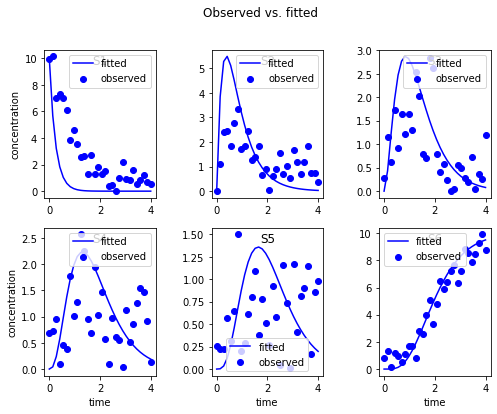

In [6]:
# Plot the fitl
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"], fitterMethods=["leastsq"],
                            bootstrapMethods=["leastsq"])
fitter.fitModel()
fitter.plotFitAll(numRow=2, numCol=3)

Note that ``fitterMethods`` is a list. This is so that you can specify a sequence of optimization methods so that the parameter fits of the $n$-th method are used as input to the $n+1$-st method.

### Random Restarts

Yet another option available is ``numRestart``. This is the number of times that a fitting method is restarted with the initial value of each parameter chosen from a uniform distribution over the range of the parameter value. ``SBstoat`` saves the parameter values that best fit the observed data.

In [7]:
for numRestart in [0, 10]:
    print("\n numRestart: %d" % numRestart)
    fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", 
                                 parametersToFit=["k1", "k2", "k3", "k4", "k5"], 
                                 fitterMethods=["leastsq"],
                                 numRestart=numRestart)
    fitter.fitModel()
    print(fitter.reportFit())


 numRestart: 0
[[Variables]]
    k1:  4.1057960498314445
    k2:  1.5752422244219209
    k3:  2.068558495759725
    k4:  2.1774960846506124
    k5:  3.32500978732957
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 180
    # variables        = 5
    chi-square         = 337.525221
    reduced chi-square = 1.92871555
    Akaike info crit   = 123.163009
    Bayesian info crit = 139.127794
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.478
    C(k2, k3) = -0.329
    C(k4, k5) = -0.282
    C(k1, k3) =  0.244
    C(k2, k4) = -0.225
    C(k3, k4) = -0.218
    C(k3, k5) = -0.204
    C(k2, k5) = -0.182
    C(k1, k4) =  0.116

 numRestart: 10
[[Variables]]
    k1:  0.9557789791153765
    k2:  2.2407432618005467
    k3:  2.96784984286306
    k4:  3.0765862159194186
    k5:  5.907791523436291
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 180
    # variable

Note that using ``numRestart=10`` results in a much lower value for chi-square, and better estimates of the parameters.

### Controlling Parameter Ranges

Another consideration is the bounds used for fitting parameters. These can be specified explicitly by using the ``SBstoat`` ``Parameter`` class.

In [8]:
k1Parameter = SBstoat.Parameter("k1", lower=0, upper=2, value=0.5)
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", [k1Parameter, "k2", "k3", "k4", "k5"])
fitter.fitModel()
print(fitter.reportFit())

[[Variables]]
    k1:  0.9557897347161006
    k2:  2.2407891847714696
    k3:  2.9676522455612266
    k4:  3.076533000601981
    k5:  5.90799231151036
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 180
    # variables        = 5
    chi-square         = 73.2546170
    reduced chi-square = 0.41859781
    Akaike info crit   = -151.822803
    Bayesian info crit = -135.858019
[[Correlations]] (unreported correlations are < 0.100)
    C(k4, k5) = -0.248
    C(k3, k4) = -0.226
    C(k2, k3) = -0.218
    C(k3, k5) = -0.211
    C(k2, k4) = -0.189
    C(k1, k2) = -0.179
    C(k2, k5) = -0.178
    C(k1, k3) = -0.147
    C(k1, k5) = -0.144
    C(k1, k4) = -0.141


### Plots

In [9]:
?fitter.plotFitAll

Signature:
fitter.plotFitAll(
    params:lmfit.parameter.Parameters=None,
    numPoint:int=None,
    **kwargs,
)
Docstring:
Plots the fitted with observed data over time.

Parameters
----------

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
    (f) rows of plots
subplotWidthSpace: float
    (f) horizontal space between plo

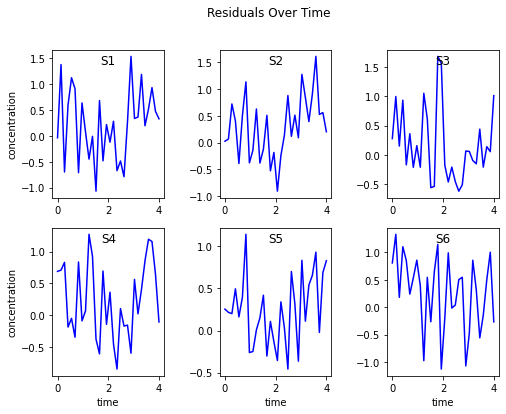

In [10]:
# Plot residuals
fitter.plotResiduals(numRow=2, numCol=3)

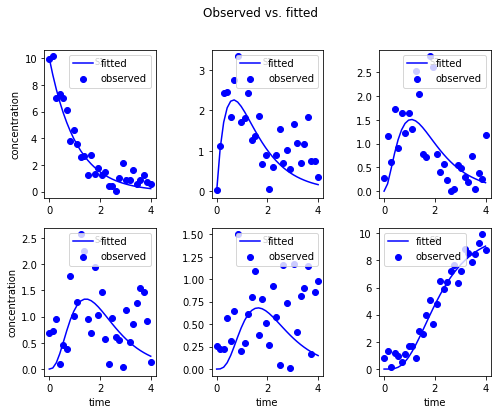

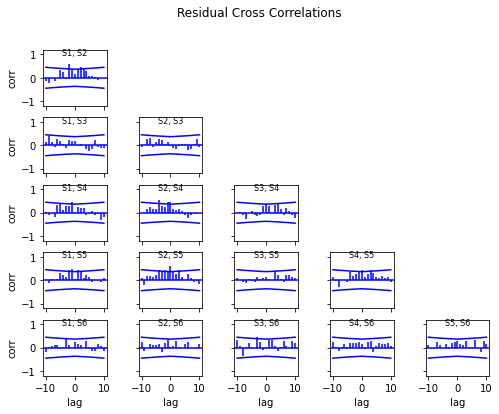

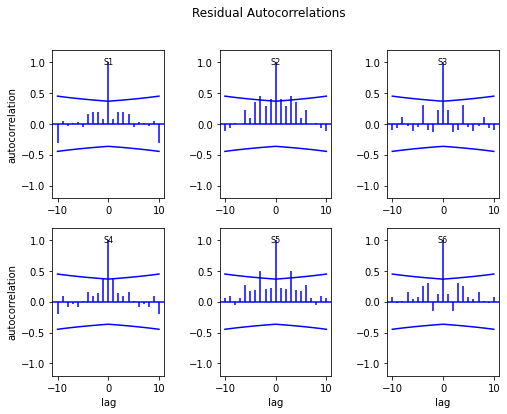

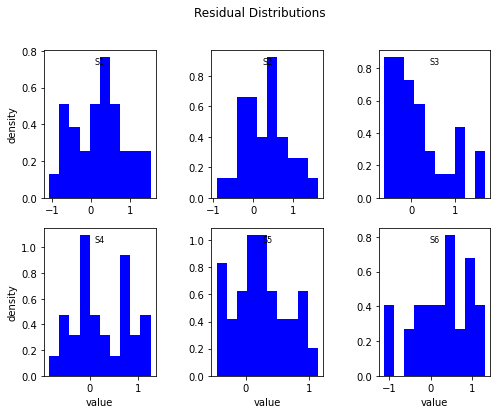

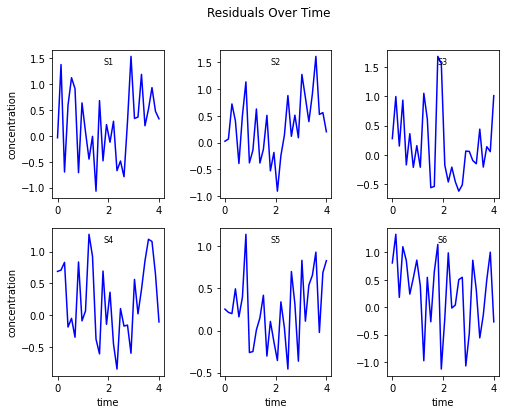

In [11]:
# Many residuals plots are available.
fitter.plotResidualsAll(numCol=3, titleFontsize=8)

### Cross Validation

You can obtain parameter estimates using cross validation. Folds are constructed by alternating time intervals.
That is, if the times are 1, 2, 3, 4 and there are two folds, then the first fold is [1, 3] and the second
fold is [2, 4]. The properties parameterDF and scoreDF provide information about the parameters and the score ($R^2$)
for each fold.

In [12]:
fitter.crossValidate(3)
fitter.parameterDF

Folds: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


,mean,std,count
parameter,,,
k1,1.001454,0.072677,3
k2,2.349240,0.376392,3
k3,2.977357,0.129060,3
k4,3.102410,0.327563,3
k5,6.034177,0.928088,3


In [13]:
# Show the R-square values for each fold
fitter.scoreDF

,score
0,0.783851
1,0.815125
2,0.764857


### Bootstrapping

In [14]:
# Get estimates of parameter variance by using bootstrapping
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"], fitterMethods=["leastsq"],
                            bootstrapMethods=["leastsq"])
fitter.bootstrap(numIteration=2000)

iteration: 100%|██████████| 2000/2000 [00:20<00:00, 97.32it/s] 




41.969260: 
 **2000 bootstrap estimates of parameters.


In [15]:
print(fitter.getParameterStds())

[0.46316210187245166, 0.2910978350898966, 0.3142021239158831, 0.29124863110029237, 0.5852877310474377]


In [16]:
print(fitter._checkFit())

None


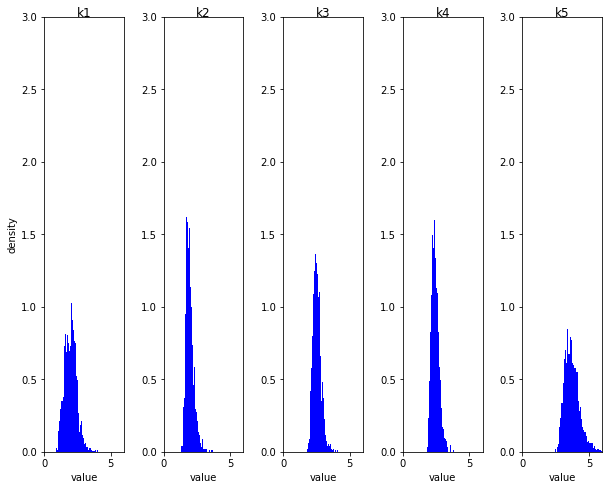

In [17]:
# Look at the distribution of the parameter fits.
fitter.plotParameterHistograms(figsize=(10,8), ylim=[0, 3], xlim=[0, 6], bins=50, titlePosition=[.5,1])

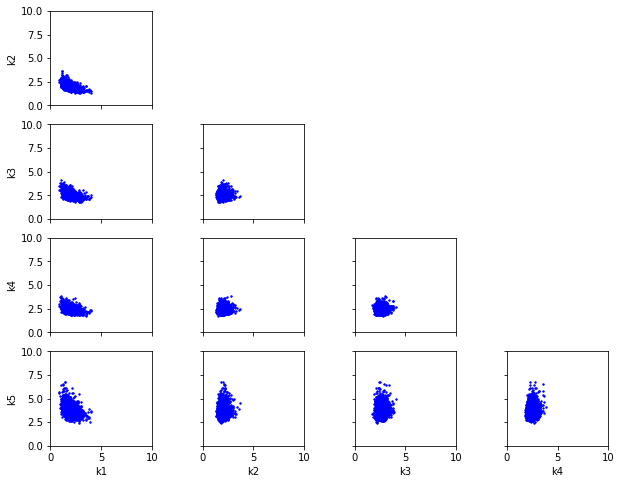

In [18]:
# Look at interactions between parameter estimates
fitter.plotParameterEstimatePairs(figsize=(10,8), ylim=[0, 10], xlim=[0, 10], markersize=2)

In [19]:
fitter.reportBootstrap()




43.035766: ***
Bootstrap Report.
Total iterations: 401000
Total simulation: 2000
k1
  mean: 1.9991906395119612
  std: 0.46316210187245166
  [2.5, 50, 97.55] Percentiles: [1.1892242  1.99868341 2.97884372]
k2
  mean: 1.9565496186100275
  std: 0.2910978350898966
  [2.5, 50, 97.55] Percentiles: [1.51868763 1.91005778 2.67611516]
k3
  mean: 2.5287630592554953
  std: 0.3142021239158831
  [2.5, 50, 97.55] Percentiles: [2.03527196 2.49241036 3.24312808]
k4
  mean: 2.4377996124575856
  std: 0.29124863110029237
  [2.5, 50, 97.55] Percentiles: [1.96832556 2.40184577 3.11890464]
k5
  mean: 3.732772412097618
  std: 0.5852877310474377
  [2.5, 50, 97.55] Percentiles: [2.85492491 3.6534794  5.15803871]***


## Suites of Models

A suite of models is a collection of model variants with overlapping parameters.
Typically, the model variants arise because of different experimental conditions, such as gene knock-outs
and changes in initial conditions (e.g., concentrations of external chemical species).
Fitting parameters for a suite of models means finding *one* set of parameter values that work well
for *all* of the models in the suite.

Consider the pathway $X0 \rightarrow S1 \rightarrow S2 \rightarrow S3 \rightarrow S4 \rightarrow X1$, where $X0, X1$ have fixed concentrations.
Suppose that two experiments are conducted for different parts of this pathway.
The first model is for $X0 \rightarrow S1 \rightarrow S2 \rightarrow S3$,
and the second is for $S2 \rightarrow S3 \rightarrow S4 \rightarrow X1$,
The kinetic constants for the first pathway are $k_1, k_2, k_3$,
and for the second $k_3, k_4, k_5$.
So, by *simultaneously* fitting both models, we need to find a value for $k_3$ that works for both models.

In [20]:
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries
from SBstoat.suiteFitter import SuiteFitter

import tellurium as te

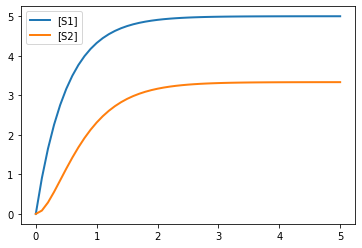

In [21]:
# Model of a linear pathway
MODEL1 = """ 
# Reactions
    J1: $X0 -> S1; k1*$X0
    J2: S1 -> S2; k2*S1
    J3: S2 -> $S3; k3*S2
# Species initializations
    X0 = 10;
    S1 = 0;
    S2 = 0;
    S3 = X0
    k1 = 1;
    k2 = 2;
    k3 = 3;
"""
PARAMETERS1 = ["k1", "k2", "k3"]
rr = te.loada(MODEL1)
model1Arr = rr.simulate()
rr.plot(model1Arr)

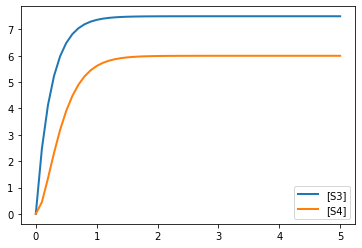

In [22]:
# Model of a linear pathway
MODEL2 = """ 
# Reactions
    J1: $S2 -> S3; k3*$S2
    J2: S3 -> S4; k4*S3
    J3: S4 -> $X1; k5*S4
# Species initializations
    S2 = 10;
    S3 = 0;
    S4 = 0;
    X1 = S2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""
PARAMETERS2 = ["k3", "k4", "k5"]
rr = te.loada(MODEL2)
data = rr.simulate()
rr.plot(data)

To illustrate fitting suites of models, we create synthetic observational data based on the true model.
There are two synthetic data sets, one for each of the experiments described above.

In [23]:
def mkSyntheticData(model, std=0.3):
    """
    Creates synthetic observations for a model by adding a normally distributed random variable with zero mean.
    
    Parameters
    ----------
    model: str
        Antimony model
    std: float
        Standard deviation of the random error
        
    Returns
    -------
        NamedTimeseries
    """
    rr = te.loada(model)
    dataArr = rr.simulate()
    fittedTS = NamedTimeseries(namedArray=dataArr)
    synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=std)
    return synthesizer.calculate()

In [24]:
data1TS = mkSyntheticData(MODEL1)
data2TS = mkSyntheticData(MODEL2)

Constructing a ``SuiteFitter`` is analogous to what is done for a ``ModelFitter``. To construct a ``ModelFitter``, there is a single model, a single data set, and a single collection of parameters to fit.
To construct a ``SuiteFitter``, there is a list of models, a list of data sets, and a list of parameters to fit. The $i$th item in each list is used to construct a separate ``ModelFitter``.
Parameters
are fit so that the same parameter in different fitters has the same value assigned.

In [25]:
# Fit the model suite
suiteFitter = SuiteFitter([MODEL1, MODEL2], [data1TS, data2TS], [PARAMETERS1, PARAMETERS2],
                         modelNames=["Model1", "Model2"], fitterMethods=["differential_evolution"])
suiteFitter.fitSuite()

Use ``reportFit`` to see the results of the fit.

In [26]:
print(suiteFitter.reportFit())

[[Variables]]
    k1:  1.0551361162346793
    k2:  2.0999333767335524
    k3:  3.156684759849823
    k4:  4.238295494035822
    k5:  5.21981715148558
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 4323
    # data points      = 204
    # variables        = 5
    chi-square         = 0.00195544
    reduced chi-square = 9.8263e-06
    Akaike info crit   = -2347.27315
    Bayesian info crit = -2330.68255
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


To see the quality of fits for each model, use ``plotFitAll``.



Model1



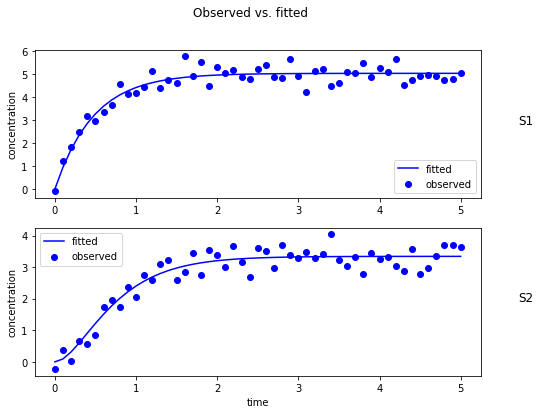



Model2



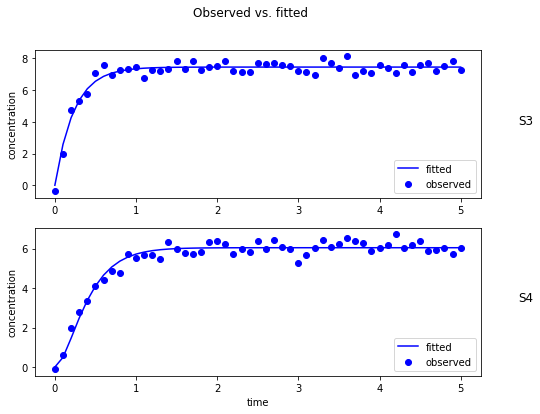

In [27]:
suiteFitter.plotFitAll(titlePosition=(1.1, 0.5))

It is sometimes useful to see how each model contributes to the residual sum of squares since it may be more difficult to fit some models.

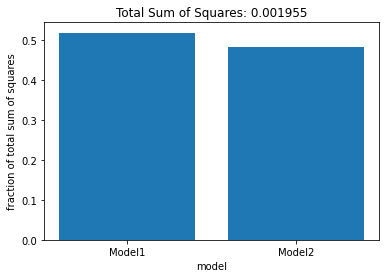

In [28]:
suiteFitter.plotResidualsSSQ()

## Manipulating Tabular Data
Tables are a great way to describe data. Tables are a collection of values organized into rows and columns. Typically, the columns have names. Common operations on tables are:

- Create a table from a file
- Create a new table from a subset of rows and/or columns
- Create new columns and/rows by performing addition, subtaction, and other operations on table rows and columns.

Many systems provide table representations. Spreadsheets are widely used. In the R language, a dataframe is a table. In python, the pandas package provides a python version of dataframes.

Pandas is very powerful, but it is slow. numpy provides arrays and matrices, but these lack the convenience of column names. In addition, the variables we analyze are collected at the same timepoints, and so it's important to associate these timepoints with the variable values.

``NamedTimeseries`` is a thin layer on top of numpy ``ndarray`` that provides an efficient table abstraction. Efficiency is a particular concern for model fitting since fitting can be very numerically intensive.

In [29]:
# Import the modules needed.
import numpy as np
TIME = SBstoat.TIME

Let's start by creating a ``NamedTimeseries`` from the file ``tst_data.txt``. In python, an object is created from a constructor that is the class name followed by arguments. There are several constructors for ``NamedTimeseries``.

In [30]:
ts1 = SBstoat.NamedTimeseries(csvPath="tst_data.txt")  # Construct from a file
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

There are 7 columns (including "time") and 30 rows. All ``NamedTimeseries`` have a "time" column. In fact, the python variable ``TIME`` can be used to reference this column.

We reference rows by their "index", their count from 0. In fact, we can make a new ``NamedTimeseries`` that consists of a subset of the rows.

In [31]:
# Get the first row
print(ts1[1])

            S1      S2      S3      S4      S5    S6
time                                                
0.1379  10.143  1.1243  1.1493  0.7275  0.2183  1.33


In [32]:
# Get rows 1, 3, 5
print(ts1[[1, 3, 5]])

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


In [33]:
# Get rows 1 through 5
# This is a slice; you specify the first row you want and where the slice stops
ts2 = ts1[1:6]
print(ts2)

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


We can also select columns. A column select produces a ``numpy`` ``ndarray``, not at ``NamedArray``. This is done so that we can manipulate column selections using the powerful numpy facilities.

In [34]:
ts2["S1"]  # Column S1 in ts2

array([10.143 ,  6.9845,  7.3271,  7.0252,  6.084 ])

To get the numpy array for a list of columns, we give the list.

In [35]:
ts2[["S1", "S2"]]

array([[10.143 ,  1.1243],
       [ 6.9845,  2.426 ],
       [ 7.3271,  2.4685],
       [ 7.0252,  1.8382],
       [ 6.084 ,  2.7645]])

To get a **new timeseries** that just has "S1", you use ``subsetColumns``.

In [36]:
ts2a = ts2.subsetColumns("S1")
print(ts2a)

             S1
time           
0.1379  10.1430
0.2759   6.9845
0.4138   7.3271
0.5517   7.0252
0.6897   6.0840


In [37]:
# Create a timeseries from ts2 with just S1, S2
print(ts2.subsetColumns(["S1", "S2"]))

             S1      S2
time                   
0.1379  10.1430  1.1243
0.2759   6.9845  2.4260
0.4138   7.3271  2.4685
0.5517   7.0252  1.8382
0.6897   6.0840  2.7645


We can add columns to the timeseries. Here, we add a column with a constant value of 1.

In [38]:
ts2["constant_1"] = 1
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1
time                                                               
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0


We can also do calculations and create new columns with the results.

In [39]:
ts2["New_Calculation"] = ts2["S1"] + np.multiply(ts2["S2"], ts2[TIME])
ts2["Other_Calculation"] = ts2["S1"] + 10*np.multiply(ts2["S2"], ts2[TIME])
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1  \
time                                                                  
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0   
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0   
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0   
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0   
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0   

        New_Calculation  Other_Calculation  
time                                        
0.1379        10.298041          11.693410  
0.2759         7.653833          13.677834  
0.4138         8.348565          17.541753  
0.5517         8.039335          17.166549  
0.6897         7.990676          25.150756  


In [40]:
# Let's get rid of Other_Calculation
del ts2["Other_Calculation"]
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1  \
time                                                                  
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0   
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0   
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0   
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0   
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0   

        New_Calculation  
time                     
0.1379        10.298041  
0.2759         7.653833  
0.4138         8.348565  
0.5517         8.039335  
0.6897         7.990676  


We can combine the rows and columns of a ``NamedTimeseries`` to make a new ``NamedTimeseries``.

In [41]:
ts3 = ts2.subsetColumns(["S1", "S2"])
ts4 = ts2.subsetColumns("S3")
ts5 = ts2.subsetColumns("New_Calculation")
ts6 = ts3.concatenateColumns([ts4, ts5])  # Has S1, S2, S3, New_Calculation"
print(ts6)

             S1      S2      S3  New_Calculation
time                                            
0.1379  10.1430  1.1243  1.1493        10.298041
0.2759   6.9845  2.4260  0.6174         7.653833
0.4138   7.3271  2.4685  1.7287         8.348565
0.5517   7.0252  1.8382  0.9091         8.039335
0.6897   6.0840  2.7645  1.6500         7.990676


In [42]:
ts7 = ts1[:2]
ts8 = ts1[2:4]
ts9 = ts1[4:6]
ts10 = ts7.concatenateRows([ts8, ts9])  # First 6 rows of ts1
print(ts10)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


In [43]:
# Save the result in a file
ts2.to_csv("new_data.csv")

In [44]:
# To see the file, we run a command in the operating system shell. The following works in Unix and Mac.
!cat new_data.csv

time,S1,S2,S3,S4,S5,S6,constant_1,New_Calculation
0.1379,10.143,1.1243,1.1493,0.7275,0.2183,1.33,1.0,10.29804097
0.2759,6.9845,2.426,0.6174,0.9473,0.2214,0.186,1.0,7.6538334
0.4138,7.3271,2.4685,1.7287,0.1039,0.566,1.1456,1.0,8.3485653
0.5517,7.0252,1.8382,0.9091,0.457,0.3135,0.9807,1.0,8.03933494
0.6897,6.084,2.7645,1.65,0.3831,0.6469,0.5328,1.0,7.99067565


## Plotting In Depth
We provide 4 types of plots with user controllable options for the plots. The plots are:

1. Plot all variables of one table on a single plot.
1. Plot all variables of one table in one plot and all variables of second plot
1. Plot each variable of a table in a separate plot
1.  Plot each variable of two tables in the same plot

In [45]:
# Create the plotter object
plotter = SBstoat.TimeseriesPlotter()

In [46]:
# To see the plotting options...
?plotter.plotHistograms

Signature: plotter.plotHistograms(timeseries, **kwargs)
Docstring:
Constructs a matrix of histographs for timeseries values.

Parameters
---------
timeseries: NamedTimeseries

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        bins: int
    (p) number of bins in a histogram plot
color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
    (f) rows of plots
subplotWidthSpace: float
  

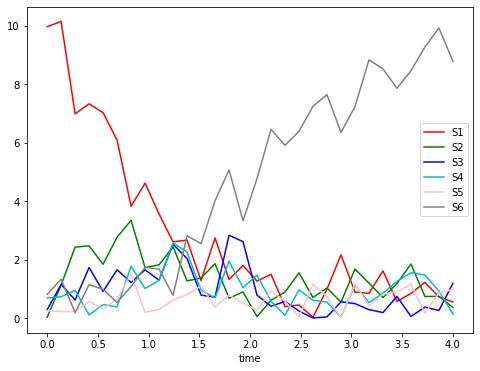

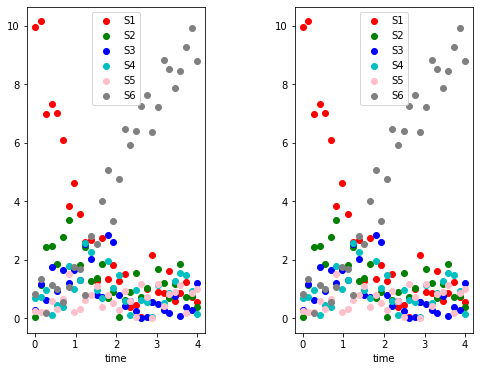

In [47]:
# Case 1: Plot all variables of a single table on a single plot
plotter.plotTimeMultiple(ts1)
plotter.plotTimeMultiple(ts1, timeseries2=ts1, marker="o")

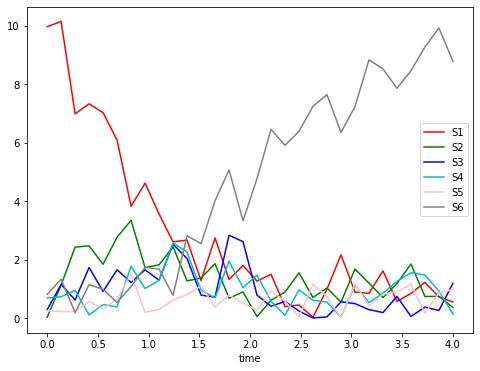

In [48]:
# We can also plot a subset of the variables in a single plot
plotter.plotTimeMultiple(ts1, columns=["S1", "S6"])

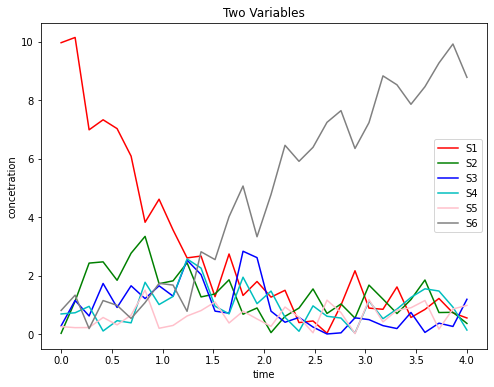

In [49]:
# Add to the plot with options
plotter.plotTimeMultiple(ts1, columns=["S1", "S6"], ylabel="concetration", title="Two Variables")

In [50]:
# Create a second table for comparisons. We can access all non-time variables using the property colnames.
ts4 = ts1.copy()  # Create a copy of the timeseries
ts4[ts4.colnames] = 5*np.cos(ts4[ts4.colnames]) + 2*ts4[ts4.colnames]

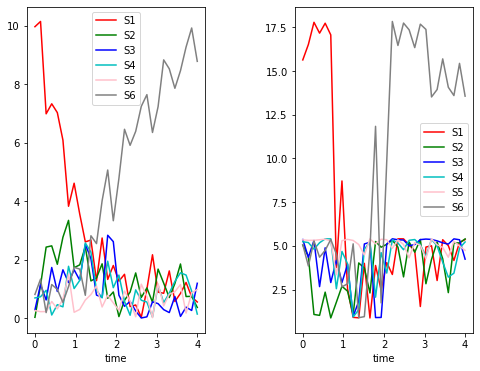

In [51]:
# Case 2: Plot two multiple variable plots, side-by-side
plotter.plotTimeMultiple(ts1, timeseries2=ts4)

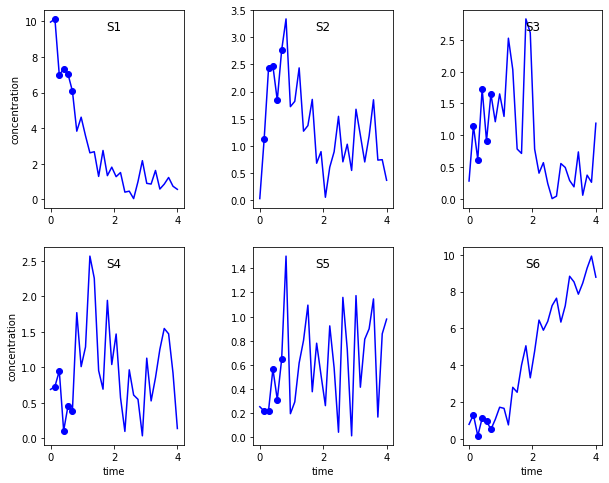

In [52]:
# Case 3: Separate plot for each variable of a single table
plotter.plotTimeSingle(ts1, numRow=2, numCol=3, timeseries2=ts2,
                      figsize=(10,8), marker="o")

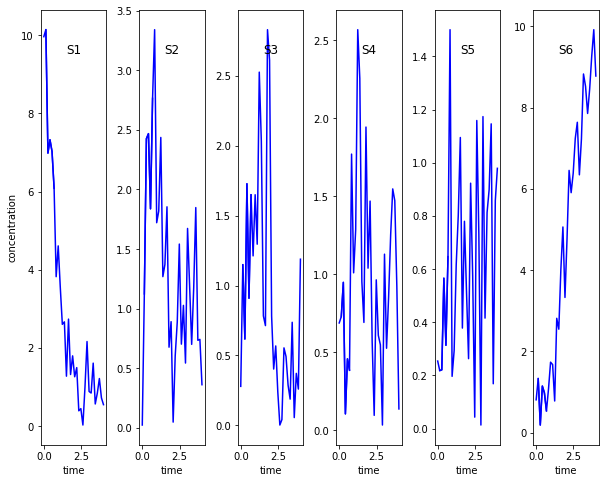

In [53]:
# Case 4: Separate plot for each variable for two tables
plotter.plotTimeSingle(ts1, timeseries2=ts2, figsize=(10, 8))

## Fitting in Depth
Kinetics models frequently have unknown constants that need to be estimated. This process of estimation is called model fitting, or just fitting. Fitting involves running multiple simulations with different values of parameters to find values that result in a good match between simulated and measured species concentrations.

In [54]:
ANTIMONY_MODEL = """ 
# Reactions   
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S4; k3*S3
    J4: S4 -> S5; k4*S4
    J5: S5 -> S6; k5*S5;
# Species initializations
    S1 = 10;
    S2 = 0;
    S3 = 0;
    S4 = 0;
    S5 = 0;
    S6 = 0;
    k1 = 1;
    k2 = 2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""

This model has the parameters ``k1, k2, k3, k4, k5``, the kinetics constants for their respective reactions. In this case, we know the true value of the parameters, which are specified at the bottom of the model. This knowledge provides a way to explore the effectiveness of model fitting.

This model is a linear pathway where mass moves from species ``S1`` to ``S6`` over time. The rate at which this happens depends on the kinetics constants.

Let's see how well we can fit this model to the ``ts1`` data described in the first section.

In [55]:
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

The fitting data has values for each of the six floating species. Model fitting works iteratively varying the values of the parameters, simulating the model with these parameters, and then evaluating how close the simulation is to the fitting data.

So, to do a fit, we must specify:

1. The model to fit
1. The fitting data
1. The parameters to estimate

To elaborate on point (3), often models contain some parameters whose values are known and others that aren't.

The class ``ModelFitter`` is used to do fitting. The constructor must specify all 3 items above. If parameters is None, then no fitting is done.

In [56]:
# Run the model using the parameter values in the model. There is no fitting.
base_fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, ts1, parametersToFit=None)

There are other options as well, such as choosing a subset of columns for the fit.

In [57]:
# Fit parameters to ts1
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"], selectedColumns=["S1", "S2"])

In [58]:
# Fit parameters to ts1 S1, S2
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"])
fitter.fitModel()

To fit a model, we use the ``fitModel`` method. We can then see the optimized residual variance and the values of the model parameters.

In [59]:
base_fitter.fitModel()

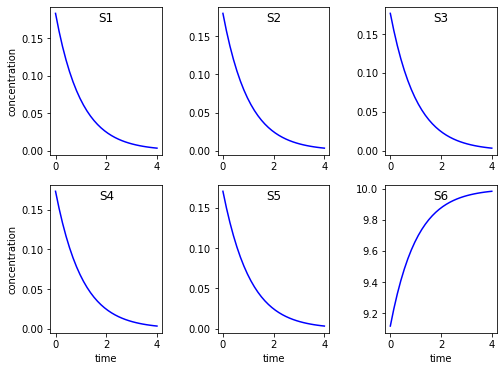

In [60]:
# The model without fitting any parameters
ts_base = SBstoat.NamedTimeseries(namedArray=base_fitter.roadrunnerModel.simulate(0, 4, 30))
plotter.plotTimeSingle(ts_base, numRow=2)

This is a bit crowded for detailed comparisons. So, we make comparisons between each variable.

In our running example, the values of parameters in the original model are their true value. Ideally, we want to achieve a variance close to this. We create a new fitter object since we still want to have access to the unchanged model that we started with.

In [61]:
parameterNames = ["k%d" % i for i in range(1, 6)]
fitter = SBstoat.ModelFitter(ANTIMONY_MODEL, ts1, parameterNames)
fitter.fitModel()
print("residual variance of the fitted model: %3.2f" % np.var(fitter.residualsTS.flatten()))
print("Values of fitted parameters: %s" % str(fitter.getParameterMeans()))

residual variance of the fitted model: 0.35
Values of fitted parameters: [0.955790182749807, 2.2407968542246457, 2.9676252513361954, 3.076524896617424, 5.908069187921925]


Now let's compare the fitted model with the data.

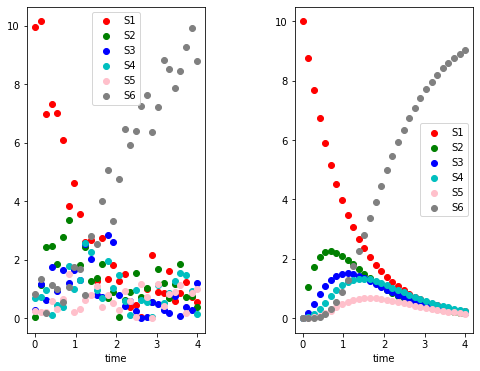

In [62]:
fittedModel = fitter.roadrunnerModel
fittedModel.reset()
fittedTS = SBstoat.NamedTimeseries(namedArray=fittedModel.simulate(ts1.start, ts1.end, len(ts1)))
plotter.plotTimeMultiple(ts1, timeseries2=fittedTS, marker="o")

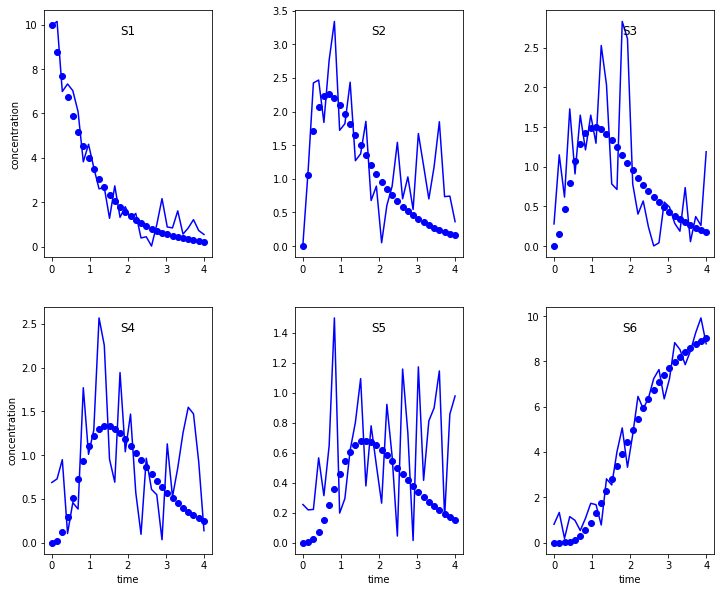

In [63]:
plotter.plotTimeSingle(ts1, timeseries2=fittedTS, numRow=2, numCol=3, figsize=(12, 10), marker="o")

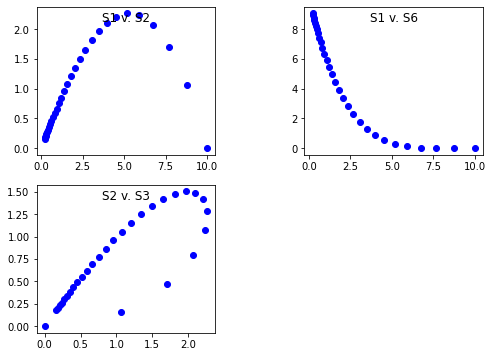

In [64]:
# Plot pairs of values
plotter.plotValuePairs(fittedTS, pairs=[("S1", "S2"), ("S1", "S6"), ("S2", "S3")], numCol=2)

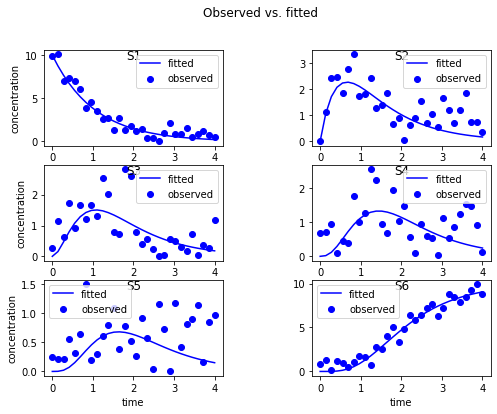

In [65]:
fitter.plotFitAll(numCol=2, numRow=1)

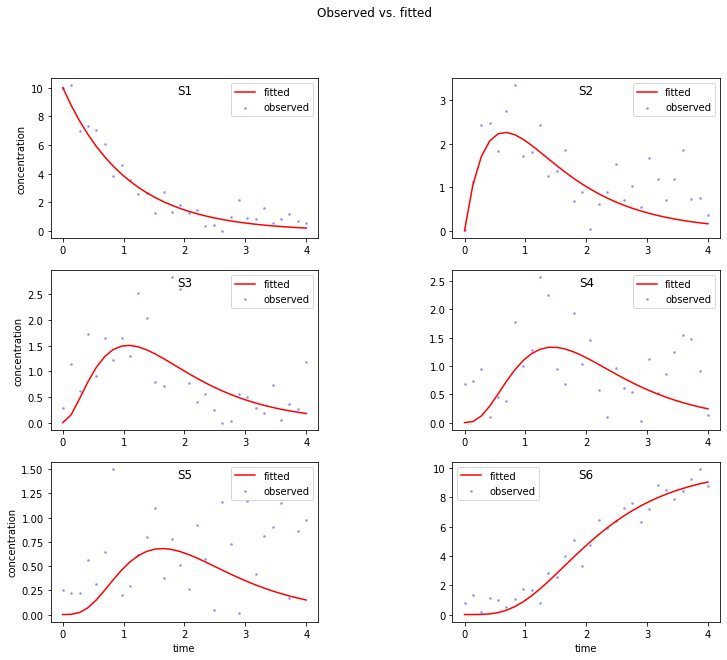

In [66]:
fitter.plotFitAll(numRow=2, numCol=2, figsize=(12, 10), color=["red", "blue"], alpha=[1.0, 0.3],
                 markersize=3)

Sometimes, the observed values are in different units than what is produced by the simulation. So, fitted values must be transformed.
This is done by specifying fittedDataTransformationDct, a dictionary of functions for transformming fitted values.